In [2]:
from brian2 import *
import sys 
sys.path.append('..')

from DynapSE import DynapSE
from Spike_G import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Display plots inside Jupyter cell
%matplotlib inline 
# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90
from equations.dynapse_eq import *
from parameters.dynapse_param import *

# C++ code generation for faster spiking network simulation
set_device('cpp_standalone')

# Ignore Brian2 base warnings/dynapse-simulator-New-Parameters/

BrianLogger.suppress_name('base')
# The clock of Brian2 simulation for numerically solve ODEs
defaultclock.dt = 20 * us

In [3]:
device.reinit()
device.activate()
defaultclock.dt = 20 * us

# Parameters
pulse_start  = 0     # second - Start timing of pulse
pulse_stop   = 1     # second - Stop timing of pulse
inp_duration = 2     # second - Simulation duration
firing_rate  = 100  # Hz - Firing rate of the source

# Create a regular spiking pattern
spikes = np.zeros(inp_duration*2000)
dt = int(2000/firing_rate)
spikes[300:500:dt] = 1.0
spikes[1200:1500:dt] = 1.0
spike_timing = np.where(spikes==1)[0] * ms
neuron_indices = np.zeros(len(spike_timing))
input_spike_generator = SpikeGeneratorGroup(1, indices=neuron_indices, times=spike_timing, name='InpSpikeGenerator')    
#input_spike_generator = PoissonGroup(1, firing_rate * Hz)

# Create a Brian2 network and chip instance using that monitors DynapSE resources.
network = Network()
chip = DynapSE(network)

# Connect a single spike generator to a single DPI neuron 
DPI_neuron  = chip.get_neurons(1, 'Core_1')
DPI_synapse = chip.add_connection(input_spike_generator, DPI_neuron, synapse_type='AMPA_STD')
chip.connect(DPI_synapse, True)
DPI_synapse.weight = 1
#DPI_synapse.d = 0.1 # this tells us the strength of depression 


#
# Using paramGen, set adaptation configurations for Core #1
# In DynapSE, parames are set per Core.
# In samna, this command is like: set_param(core_id, param_name, fine_value, coarse_value)
adaptation_conf = {
    "Isoma_dpi_tau" :  7.5* pA,
    "Isoma_th"  : 10* nA,  
    "alpha_soma": 3,
    
    "Isoma_ahp_tau": 11 * pA,             
    "Isoma_ahp_w" : 0 * pA,
    "alpha_ahp"  : 1,  
    
    "soma_refP": 20 * ms,
    "Isoma_const": 300 *pA
                }

ampa_conf = {        "Iampa_std_tau": 10 * pA,
        "Va" :150*mV,
        "Vw" :150*mV,
        "tau_pulse" : 3 *ms,
        "Idischarge_w":5*pA,


        "Iampa_w0":20*pA}

# merge the param dict into 1.
core_conf = {**ampa_conf,**adaptation_conf}
# set the params
chip.set_bias(core_conf, 'Core_1')

# Monitors
mon_neuron_input  = SpikeMonitor(input_spike_generator, name='mon_neuron_input')


mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')
mon_synapse_ampa  = StateMonitor(DPI_synapse, 'Iampa_std', record=[0])
mon_synapse_Vw  = StateMonitor(DPI_synapse, 'Vw', record=[0])
mon_synapse_std_pulse  = StateMonitor(DPI_synapse, 'std_pulse', record=[0])
mon_synapse_Ia  = StateMonitor(DPI_synapse, 'Ia',record=[0])
mon_mem_state  = StateMonitor(DPI_neuron,  'Isoma_mem', record=True)
network.add([input_spike_generator, DPI_neuron, DPI_synapse])
network.add([mon_neuron_input,mon_neuron_output,mon_synapse_std_pulse,mon_synapse_ampa,mon_synapse_Vw,mon_synapse_Ia])

# Simulation
network.run(inp_duration * 1000 * ms)



1 neurons are allocated from Core_1.
New bias values are loaded to Core_1.


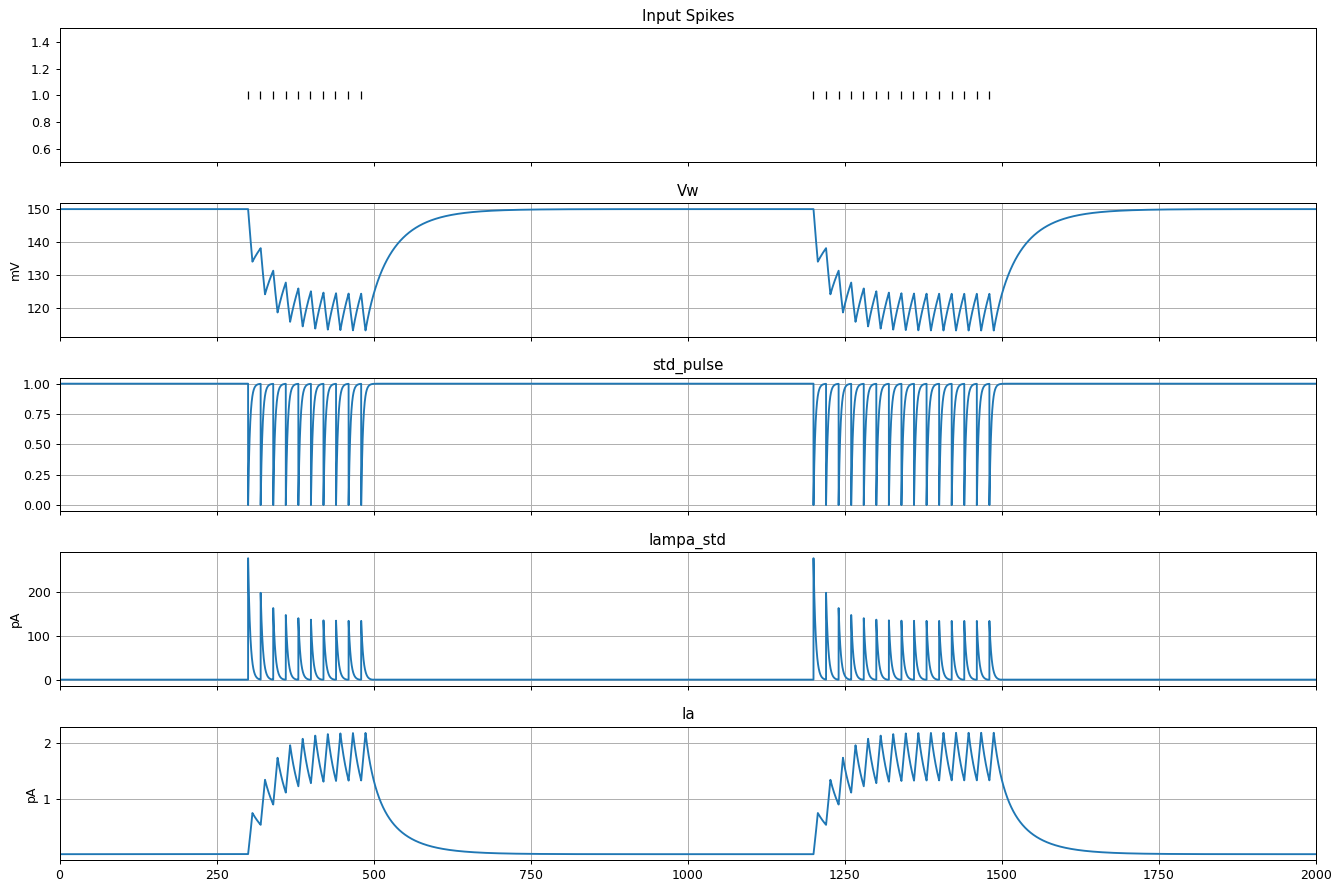

In [4]:
tstart = 0 # ms  
tend   = 2000 # ms 
s = int(1*ms / defaultclock.dt)

times = int(inp_duration/ms)


fig, (ax1,ax2,ax3,ax4,ax5) =plt.subplots(5,sharex=True)

fig.set_figheight(10)
fig.set_figwidth(15)

spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=1
ax1.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
ax1.set_ylim(0.5, 1.5)
ax1.set_title('Input Spikes')


ax2.plot(mon_synapse_Vw.t[tstart*s:tend*s]/ms, mon_synapse_Vw.Vw[0][tstart*s:tend*s]/mV,linewidth=1.5)
ax2.set_title('Vw')
ax2.set_ylabel('mV')
ax2.grid(True)
ax2.set_xlim(0,2000)


ax3.plot(mon_synapse_std_pulse.t/ms, mon_synapse_std_pulse.std_pulse[0],linewidth=1.5)
ax3.set_title('std_pulse')
ax3.grid(True)







ax4.plot(mon_synapse_ampa.t[tstart*s:tend*s]/ms, mon_synapse_ampa.Iampa_std[0][tstart*s:tend*s]/pA, linewidth=1.5, label='AMPA')
#plt.legend(['$I_ampa_std$'],loc='upper right')
ax4.set_title('Iampa_std')
ax4.set_ylabel('pA')
#plt.xlabel('Time (ms)')
ax4.grid(True)



#plt.subplot(515)
ax5.plot(mon_synapse_Ia.t[tstart*s:tend*s]/ms, mon_synapse_Ia.Ia[0][tstart*s:tend*s]/pA, linewidth=1.5, label='AMPA')
#plt.legend(['$I_ampa_std$'],loc='upper right')
ax5.set_title('Ia')
ax5.set_ylabel('pA')
#plt.xlabel('Time (ms)')
ax5.grid(True)
fig.tight_layout()




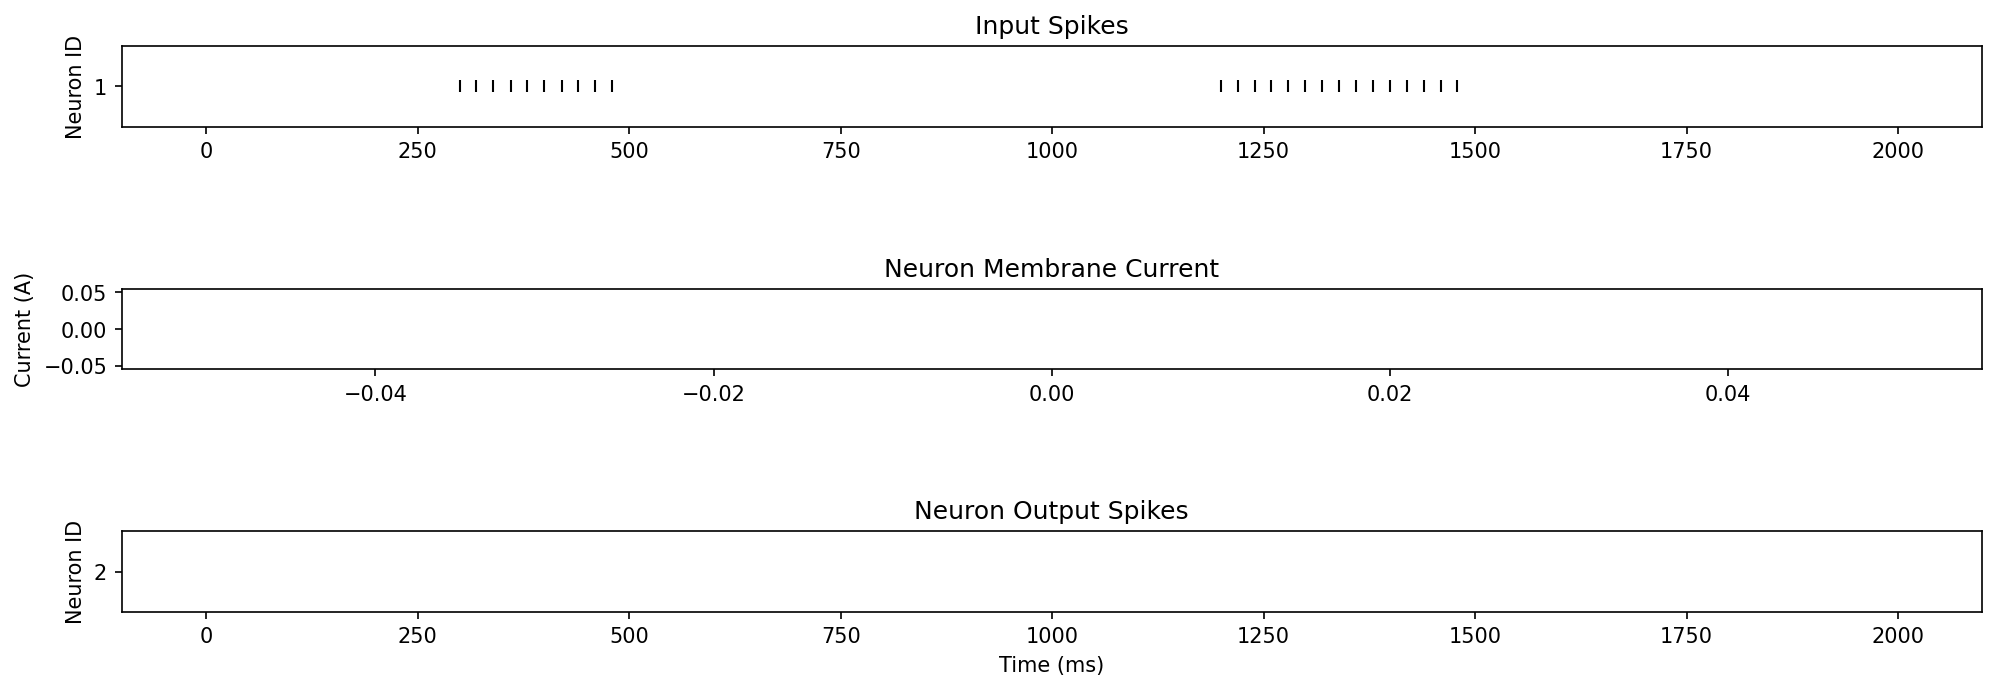

In [29]:
# plotting
plt.figure(figsize=(16,5),dpi=150)
plt.subplots_adjust(hspace=2)

times = int(inp_duration/ms)

# Input Spikes 
plt.subplot(311)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
plt.title('Input Spikes')
plt.ylabel('Neuron ID')
#plt.xlabel('Time (ms)')

plt.subplot(312)
Imem = mon_mem_state.Isoma_mem[0]
plt.plot(mon_mem_state.t/ms, Imem)

plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
#plt.xlabel('Time (ms)')

plt.subplot(313)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_output.t/ms, dtype=int)]=2
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(1.5, 2.5)
plt.title('Neuron Output Spikes')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')
plt.show()

In [5]:
print('time constant of Isyn', DPI_synapse.std_pulse[0])
print('time constant of Imem', DPI_neuron.tau_soma)
print('Input firing rate = ', mon_neuron_input.count/ (inp_duration* 1000 * ms))
print('Output firing rate = ', mon_neuron_output.count/ (inp_duration* 1000 * ms))
print('number of input spikes',mon_neuron_input.count[0])
print('number of output spikes',mon_neuron_output.count[0])

time constant of Isyn 0.9999999999999917
time constant of Imem <Core_1_subgroup.tau_soma: array([9.45626478]) * msecond>
Input firing rate =  [62.5] Hz
Output firing rate =  [0.] Hz
number of input spikes 125
number of output spikes 0


In [6]:
mon_synapse_std_pulse.std_pulse

array([[1., 1., 1., ..., 1., 1., 1.]])